In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

from eulers_method import euler_method
from gillespie import Gillespie

In [2]:
plt.figure()
sns.set_style("ticks")
sns.set_palette(sns.color_palette())

<Figure size 640x480 with 0 Axes>

In [3]:
def dy_dx(y):
    return -2 * y**2

In [4]:
step_sizes = [0.005, 0.001, 0.0001]
df_tot = pd.DataFrame()
for h in step_sizes:
    x, y = euler_method(dy_dx, h)
    df = pd.DataFrame()
    df["x"] = x
    df["y"] = y
    df["h"] = str(h)

    df_tot = pd.concat([df_tot, df])

In [5]:
x_exact = np.arange(0, 0.1, 0.00001)
y_exact = 100 / (1 + 200 * x_exact)
df = pd.DataFrame()
df["x"] = x_exact
df["y"] = y_exact
df["h"] = "Analytical"
df_solutions = pd.concat([df_tot, df]).reset_index()

df_tot = df_tot.reset_index()
df_tot.head()

,index,x,y,h
0,0,0.000,100.0,0.005
1,1,0.005,0.0,0.005
2,2,0.010,0.0,0.005
3,3,0.015,0.0,0.005
4,4,0.020,0.0,0.005


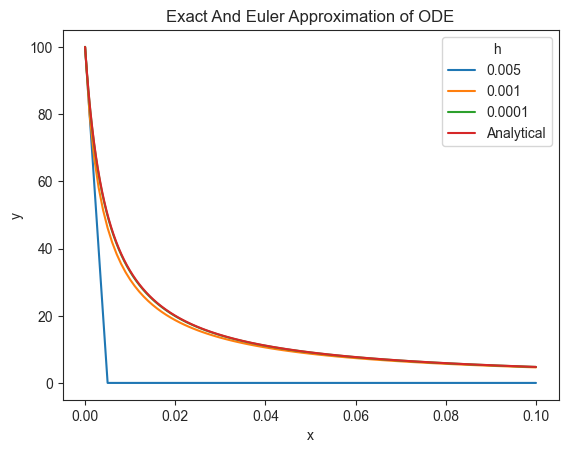

In [6]:
g = sns.lineplot(data=df_solutions, x="x", y="y", hue='h')
plt.title("Exact And Euler Approximation of ODE")
plt.savefig("../../data/euler_approx.png")

In [7]:
y_error = np.zeros(len(df_tot))
for index, row in df_tot.iterrows():
    y_error[index] = row['y'] - (100/1 + 200*row["x"])
df_tot["y error"] = y_error

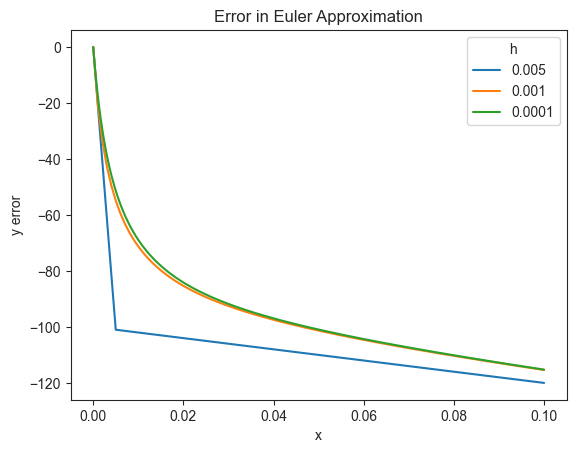

In [8]:
g = sns.lineplot(data=df_tot, x='x', y='y error', hue='h')
plt.title("Error in Euler Approximation")
plt.savefig("../../data/euler_error.png")

In [9]:
class ReactionParameters:
    A = 1.5
    B = 4

    V = 2.0
    x_init = 5.0
    y_init = 1.0
    k1, k2, k3, k4 = 1.0, 1.0, 1.0, 1.0

    def __init__(self):
        self.c1 = self.k1
        self.c1_A = self.c1 * self.A*self.V
        self.c2 = 2 * self.k2/self.V/self.V
        self.c3 = self.k3/self.V
        self.c3_B = self.k3 * self.B * self.V
        self.c4 = self.k4

        self.x_init_n = int(self.x_init * self.V)
        self.y_init_n = int(self.y_init * self.V)

In [10]:
def reaction_ode(state, t, pm=ReactionParameters()):
    y1, y2 = state
    dy_dt = [pm.k1 * pm.A + pm.k2 * y1 * y1 * y2 - pm.k3 * pm.B * y1 - pm.k4 * y1,
             pm.k3 * pm.B * y1 - pm.k2 * y1 * y1 * y2]
    return dy_dt

In [11]:
pm = ReactionParameters()
s0 = [pm.x_init, pm.y_init]
t = np.linspace(0, 25, 1001)

analytic_solution = pd.DataFrame(odeint(reaction_ode, s0, t))
analytic_solution.columns = ["x", "y"]
analytic_solution["time (tu)"] = t

df_sol = analytic_solution.melt(id_vars = ["time (tu)"], var_name='variable', value_name='# per vol ($\mu m^{-3}$)')
df_sol.head()

,time (tu),variable,# per vol ($\mu m^{-3}$)
0,0.000,x,5.000000
1,0.025,x,5.006065
2,0.050,x,4.967114
3,0.075,x,4.902705
4,0.100,x,4.824636


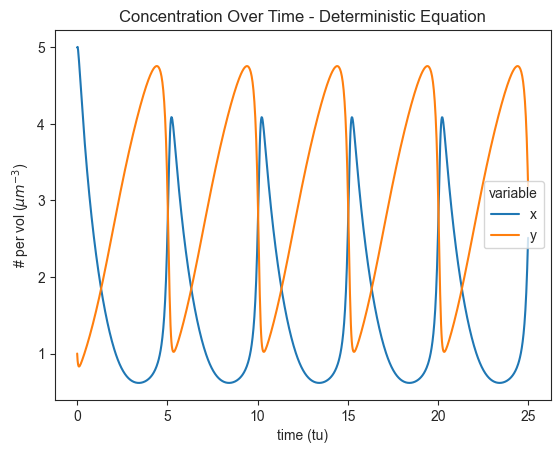

In [12]:
g = sns.lineplot(data=df_sol, x='time (tu)', y='# per vol ($\mu m^{-3}$)', hue="variable")
plt.title("Concentration Over Time - Deterministic Equation")
plt.savefig("../../data/reaction_kinetics.png")

In [13]:
np.random.seed(123)
df_gillespie = pd.DataFrame()
propensity_functions = [lambda _, __: pm.c1_A,
                        lambda x,y: pm.c2 * x * (x - 1)/2 * y,
                        lambda x,y: pm.c3_B * x,
                        lambda x,y: pm.c4 * x]
initial_state = [pm.x_init_n, pm.y_init_n]
reaction_matrix = np.array([[1, 0], [1, -1], [-1, 1], [-1, 0]])

simulation = Gillespie(initial_state, reaction_matrix, propensity_functions, max_time=25.0, M=4)

In [14]:
df_stochastic_simulation = pd.DataFrame()
x, y, t = simulation.run()

df_stochastic_simulation["x"] = x
df_stochastic_simulation["y"] = y
df_stochastic_simulation["time (tu)"] = t

df_stochastic_simulation = df_stochastic_simulation.melt(id_vars=["time (tu)"], var_name='variable', value_name='copy numbers')
df_stochastic_simulation.head()

,time (tu),variable,copy numbers
0,0.000000,x,10
1,0.002621,x,11
2,0.014077,x,10
3,0.016462,x,9
4,0.016603,x,8


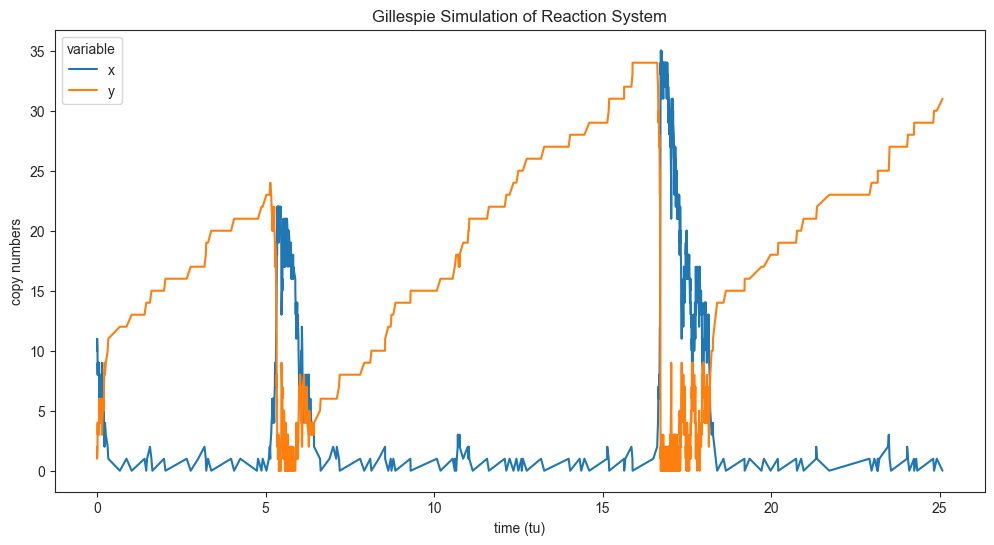

In [15]:
plt.figure(figsize=[12,6])
g = sns.lineplot(data=df_stochastic_simulation, x="time (tu)", y="copy numbers", hue="variable")
plt.title("Gillespie Simulation of Reaction System")
plt.savefig("../../data/gillespie_system.png")

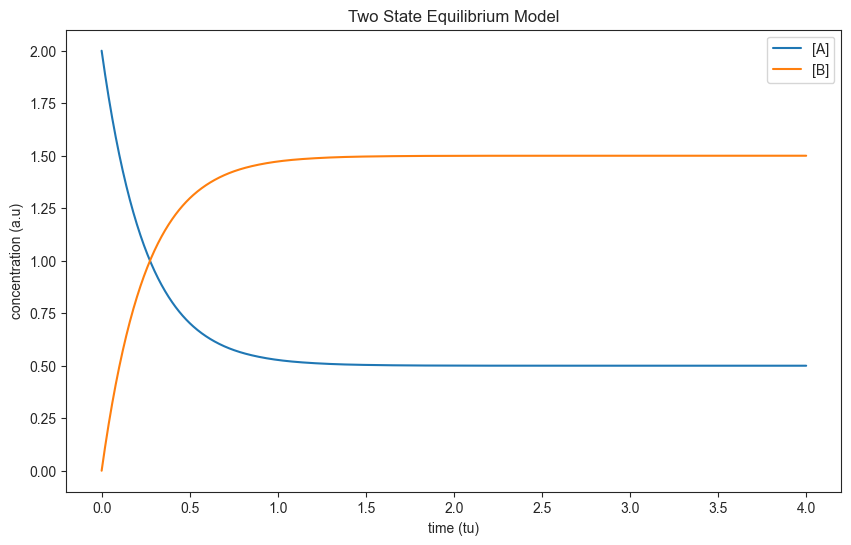

In [16]:
def dr_dt(t, z, k_on, k_off):
    ca = z[0]
    cb = z[1]

    dc_dt = -k_on*ca + k_off*cb

    return np.array([dc_dt, -dc_dt])

# Set time axis scale and initial conditions
times = np.linspace(0, 4, 1000)
c_tot = 2 # total concentration of both species
initial_concentration = np.array([c_tot, 0])

# Solve differential equation
sol = solve_ivp((lambda t, z: dr_dt(t, z, 3, 1)), np.array([0, 4]), initial_concentration, t_eval=times)

# Plot
t = sol.t
ca = sol.y[0]
cb = sol.y[1]

plt.figure(figsize = [10,6])
plt.plot(t, ca, label='[A]')
plt.plot(t, cb, label='[B]')
plt.xlabel('time (tu)')
plt.ylabel('concentration (a.u)')
plt.legend()
plt.title("Two State Equilibrium Model")
plt.savefig("../../data/two_state_model.png")
plt.show()

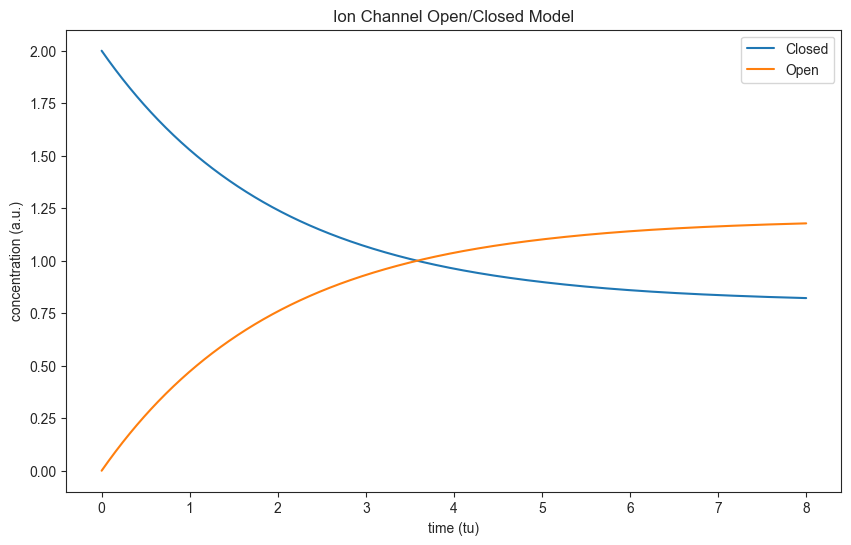

In [17]:
times = np.linspace(0, 8, 1000)
c_tot = 2 # total concentration of both species
initial_concentration = np.array([c_tot, 0])

sol = solve_ivp((lambda t, z: dr_dt(t, z, 0.3, 0.2)), np.array([0, 8]), initial_concentration, t_eval=times)

# Plot
t = sol.t
c_closed = sol.y[0]
c_open = sol.y[1]

plt.figure(figsize = [10,6])
plt.plot(t, c_closed, label='Closed')
plt.plot(t, c_open, label='Open')
plt.xlabel('time (tu)')
plt.ylabel('concentration (a.u.)')
plt.title("Ion Channel Open/Closed Model")
plt.legend()
plt.savefig("../../data/ion_channel_two_state.png")
plt.show()